In [16]:
import torch
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from tqdm import tqdm

from tqdm.notebook import tqdm
import numpy as np

from sklearn.model_selection import ParameterGrid

from torchinfo import summary

In [17]:
random_seed = 52
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [18]:
transform = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])

train_data = datasets.EMNIST(
    root='data',
    split='letters',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.EMNIST(
    root='data',
    split='letters',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 561753746/561753746 [07:51<00:00, 1191185.88it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [20]:
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Train size: {len(train_data)}")
print(f"Classes: {train_data.classes}")

Train size: 124800
Test size: 20800
Train size: 124800
Classes: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [21]:
n_classes = len(train_data.classes)
n_classes

27

In [22]:
image_size = train_data[0][0].size()[-1]
image_size

28

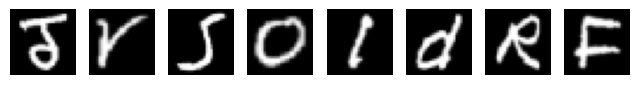

Labels: ['j', 'r', 's', 'o', 'i', 'd', 'r', 'f']


In [28]:
figure = plt.figure(figsize=(8, 5))
examplesCount = 8
examplesLabels = []
g = torch.Generator()
g.manual_seed(random_seed)
for i in range(1, examplesCount + 1):
    sample_idx = torch.randint(len(train_data), size=(1,), generator=g).item()
    img, label_idx = train_data[sample_idx]
    examplesLabels.append(train_data.classes[label_idx])
    figure.add_subplot(1, examplesCount, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"Labels: {examplesLabels}")

## Training

In [12]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()

    output = model(x_batch.to(device))

    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss/total

def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for _ in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True),
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))

        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})

def train_quality(model,
                  dataset,
                  loss_function,
                  batch_size):

    batch_generator = torch.utils.data.DataLoader(dataset=dataset,
                                                  batch_size=batch_size)

    pred = []
    real = []
    test_loss = 0

    for (x_batch, y_batch) in batch_generator:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)

        test_loss += loss_function(output, y_batch).cpu().item() * len(x_batch)

        pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
        real.extend(y_batch.cpu().numpy().tolist())

    test_loss /= len(dataset)

    return test_loss, pred, real

## Tensorboard callback

In [ ]:
class tensorboard_callback:
    def __init__(self, writer, dataset, loss_function, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)

        if self.step % self.delimeter == 0:
            self.writer.add_graph(model, self.dataset[0][0].view(1, 1, 28, 28).to(model.device))
            test_loss, pred, real = train_quality(model=model, dataset=self.dataset,
                                                  loss_function=self.loss_function, batch_size=self.batch_size)
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)


## Model

In [21]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
            
    def __init__(self,     
                 n_layers = 1,
                 kernel_size = 3,
                 max_pool = False,
                 batch_norm = False,
                 dropout = 0.0):
        
        super().__init__()

        self.n_channels = 1
        self.layers = torch.nn.Sequential()

        for layer in range(n_layers):
            self.layers.add_module(f"Conv2d[{layer}]", torch.nn.Conv2d(self.n_channels, 
                                                                       self.n_channels * 4, 
                                                                       kernel_size=kernel_size))
            self.n_channels *= 4

            if batch_norm:
                self.layers.add_module(f'BatchNorm2d[{layer}]', torch.nn.BatchNorm2d(self.n_channels))

            self.layers.add_module(f'ReLU[{layer}]', torch.nn.ReLU())

            if max_pool:
                self.layers.add_module(f'MaxPool2d[{layer}]', torch.nn.MaxPool2d(kernel_size=2))

        self.layers.add_module('Flatten[0]', torch.nn.Flatten())
        self.layers.add_module('Dropout[0]', torch.nn.Dropout(dropout))
        in_features = int(self.n_channels * self.size**2)
        print(f'n_features {in_features}')
        self.layers.add_module('Linear[0]', torch.nn.Linear(in_features, n_classes))

    def forward(self, input):
        return self.layers(input)

  0%|          | 0/16 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

## Processing

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

batch_size = 128

grid = ParameterGrid({
    'n_layers': [2],
    'kernel_size': [3, 7],
    'max_pool': [True, False],
    'batch_norm': [False, True],
    'dropout': [0.0, 0.5],
})

scores = dict()

for params in tqdm(grid):
    print(str(params))

    # Create model
    model = CNN(**params)
    mod = model.to(device)
    
    writer = SummaryWriter(f'runs/{str(params)}')
    callback = tensorboard_callback(writer, test_data, loss_function, batch_size=batch_size, delimeter=10)

    trainer(count_of_epoch=1,
            batch_size=batch_size,
            dataset=train_data,
            model=model,
            loss_function=loss_function,
            optimizer=optimizer,
            lr=0.001,
            callback=callback)

In [13]:
# !unzip experiment.zip -d .
%load_ext tensorboard
%tensorboard --logdir runs --port=8080

## Conclusions 

Была реализована модель CNN и проведён grid-search по параметрам:

- В среднем лучше качество у моделей с 2мя слоями, а не 3мя, что неожиданно (видимо, сеть получилась слишком богатой), но при большем размере ядра (а это можно было ожидать, больше размер ядра - больше рецептивное поле).

- Dropout практически не повлиял на результаты, что менее ожидаемо (учитывая его диапазон вариации при grid-search'е).

- Неожиданно, что лучший score вышел у модели без pooling слоёв.

- Batch normalization ожидаемо ускорила сходимость.